In [1]:
import os
wd = os.getcwd()
wd


'/Users/joshi27s/Desktop/Summer 2020/Yield'

In [146]:
import warnings
warnings.filterwarnings('ignore')

from fredapi import Fred
import quandl

import datetime
from datetime import date, timedelta

import numpy as np
from numpy import concatenate
import math
from math import sqrt # for RMSE
import pandas as pd
import scipy
import statsmodels.api as sm

from fbprophet import Prophet # for forecasting via ML called "Prophet"
from fbprophet.plot import plot_plotly
import logging
logging.getLogger().setLevel(logging.ERROR) # mutes unimportant diagnostic messages

import sklearn.decomposition as sck_dec # has PCA functionalities
import sklearn.decomposition.pca as PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # for standardizing the Data
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank


from pandas import read_csv, DataFrame, concat
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
matplotlib.style.use('ggplot')
%matplotlib inline


# standardizes the size of all plots, rather than typing plot(figsize = (12,6)) everytime
from pylab import rcParams
rcParams['figure.figsize'] = 12,6 

import seaborn as sns
from plotly import __version__ 
import cufflinks as cf 
from IPython.display import display, HTML, Image
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go

# set plotly to offline mode for easy reproducibilty
import plotly.offline as py
py.init_notebook_mode()


from statsmodels.tsa.stattools import adfuller,grangercausalitytests, ccovf,ccf,periodogram
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import VAR


import keras
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import *

quandl.ApiConfig.api_key = '-kesKc4A8jkkBwyX3rSX'
fred = Fred(api_key='7e70df3f020852ea824275ce0fea70a0')

In [3]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

week = ["FRED/CCSA", # UI claims - weekly;                                              Jan 1, 1967 to June 13,2020
    
    "FRED/WALCL", # Total Assets (Less Eliminations From Consolidation) - weekly;     Dec 16, 2002 - June 24,2020
    
    "FRED/RPONTSYD"] # Overnight Repurchase Agreements: Treasury Securities Purchased by Fed in OMO - weekly
                                                                                       # July 3,2000 to July 1,2020
    

In [272]:
daily = [
    
    "FRED/T10Y3M", # 10 year treasury constant maturity - 3 month tres cons mat         Jan 4, 1982 to July 2,2020
    
    "FRED/TEDRATE",  # TED Spread - daily ;                                            Jan 1, 1986 to June 24,2020
    
    "FRED/THREEFF1" , # Fitted Instantaneous Forward Rate 1 Year Hence - daily;         Jan 1,1990 to June 19,2020
    
    "FRED/USRECD", # NBER based recession indicator - daily                            July 1854 to June 30, 2020
    
    "FRED/T1YFF" , # 1-Year Treasury Constant Maturity Minus Federal Funds Rate        Jan 1, 1962 to June 30,2020
    
    "FRED/THREEFYTP10" ] # Term Premium on a 10 Year Zero Coupon Bond - daily         Jan 1,1990 to June 26,2020




yieldd = quandl.get(daily, start_date = "1990-01-01", end_date="2020-06-01", collapse = 'daily',date_parser=parser)
yieldd.columns = [
                  'yieldsp',
                  'ted', 
                  'forward1yr',
                  'rec_ind',
                  '1yr-ffr',
                  'termpr'
                  ]
   
yieldd = yieldd.fillna(method = 'bfill')
yieldd.head()

yieldsp   ted  forward1yr  rec_ind  1yr-ffr  termpr
Date                                                           
1990-01-01     0.11  0.80      7.8401      0.0    -0.73  1.6625
1990-01-02     0.11  0.80      7.8401      0.0    -0.73  1.6625
1990-01-03     0.10  0.75      7.8880      0.0    -0.52  1.6865
1990-01-04     0.14  0.79      7.8773      0.0    -0.47  1.6890
1990-01-05     0.20  0.84      7.8694      0.0    -0.41  1.7017

In [273]:
fredf = {}
fredf['sahm'] = fred.get_series('SAHMREALTIME', observation_start='1990-01-01', observation_end='2020-06-01')
fredf['infexp'] = fred.get_series('MICH', observation_start='1990-01-01', observation_end='2020-06-01')
fredf['vix'] = fred.get_series('VIXCLS', observation_start='1990-01-01', observation_end='2020-06-01')
fredf = pd.DataFrame(fredf)

# apply cubic spline interpolation to get daily value of sahm rule from monthly values
# bfill = use next valid observation to fill gap.
upsample = fredf.resample('D').interpolate(method='cubic').fillna(method = 'bfill')
upsample.index.name = 'Date'
upsample.head()

sahm    infexp    vix
Date                                 
1990-01-01  0.130000  4.100000  17.24
1990-01-02  0.132076  4.121014  17.24
1990-01-03  0.133962  4.140169  18.19
1990-01-04  0.135664  4.157512  19.22
1990-01-05  0.137187  4.173091  20.11

In [274]:
yield_d = pd.merge(yieldd, upsample, on = 'Date')
yield_d.head()

yieldsp   ted  forward1yr  rec_ind  1yr-ffr  termpr      sahm  \
Date                                                                        
1990-01-01     0.11  0.80      7.8401      0.0    -0.73  1.6625  0.130000   
1990-01-02     0.11  0.80      7.8401      0.0    -0.73  1.6625  0.132076   
1990-01-03     0.10  0.75      7.8880      0.0    -0.52  1.6865  0.133962   
1990-01-04     0.14  0.79      7.8773      0.0    -0.47  1.6890  0.135664   
1990-01-05     0.20  0.84      7.8694      0.0    -0.41  1.7017  0.137187   

              infexp    vix  
Date                         
1990-01-01  4.100000  17.24  
1990-01-02  4.121014  17.24  
1990-01-03  4.140169  18.19  
1990-01-04  4.157512  19.22  
1990-01-05  4.173091  20.11

In [275]:
yield_d.to_csv('yield_d.csv')

In [276]:
print('Number of rows and columns after removing missing values:', yield_d.shape)
print('The time series starts from: ', yield_d.index.min())
print('The time series ends on: ', yield_d.index.max())

Number of rows and columns after removing missing values: (11110, 9)
The time series starts from:  1990-01-01 00:00:00
The time series ends on:  2020-06-01 00:00:00


In [277]:
yield_d.isnull().sum()

yieldsp       0
ted           0
forward1yr    0
rec_ind       0
1yr-ffr       0
termpr        0
sahm          0
infexp        0
vix           0
dtype: int64

## Statistical Normality Test
There are several statistical tests that we can use to quantify whether our data looks as though it was drawn from a Gaussian distribution. And we will use D’Agostino’s K^2 Test.

In the SciPy implementation of the test, we will interpret the p value as follows.

p <= alpha: reject H0, not normal. p > alpha: fail to reject H0, normal.

In [278]:
from scipy import stats
stat, p = stats.normaltest(yield_d.yieldsp)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=2934.813, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -1.0258495979693147
Skewness of normal distribution: -0.07879335804725332


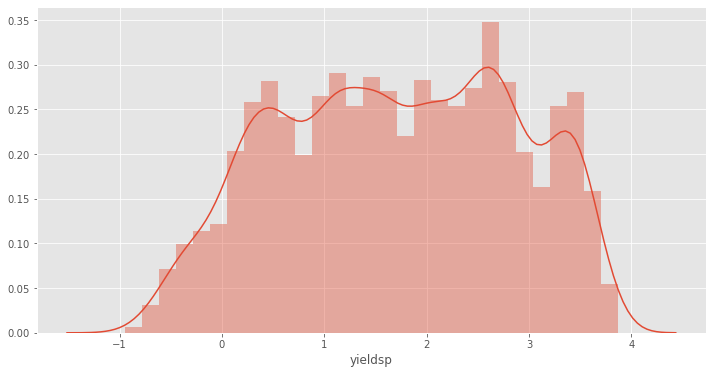

In [279]:
# calculate kurtosis and skewness, to determine if the data distribution departs from the normal distribution.
sns.distplot(yield_d.yieldsp);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(yield_d.yieldsp)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(yield_d.yieldsp)))

KURTOSIS: describes heaviness of the tails of a distribution

Normal Distribution has a kurtosis of close to 0. If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero.

SKEWNESS:

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

In [280]:
def adfuller_test(series, signif = 0.05, name = '', verbose = False):
    """Perform ADFuller to test for stationarity of a given series and print report"""
    
    r = adfuller(series, autolag = 'AIC')
    output = {'test_statistic': round(r[0], 4), 'pvalue': round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length = 6): return str(val).ljust(length)
    
    # print sumamry
    print(f'     Augmented Dickey-Fuller Test on "{name}"', "\n    ", '-'*47)
    print(f'  Null Hypothesis: Data has unit too. Non-Stationary.')
    print(f'  Significance Level    = {signif}')
    print(f'  Test Statistic        = {output["test_statistic"]}')
    print(f'  No. of Lags Chosen    = {output["n_lags"]}')
          
    for key, val in r[4].items():
          print(f'  Critical Value {adjust(key)} = {round(val, 3)}')
          
    if p_value <= signif:
          print(f" => P-Value = {p_value}. Rejecting null hypothesis.")
          print(f" => Series is stationary.")
    else:
          print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
          print(f" => Series is non-stationary.")
 

In [281]:
data_list = yield_d[list(yield_d.columns)]

#data_list = yield_d[['ffr', 'rec_prob', 'epop', 'rwage', 'sahm', 'rgdp_change', 'house_st_change',
      # 'ipi_change']]

# ADF Test on the levelled (original) values each column
for name, column in data_list.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "yieldsp" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -2.4411
  No. of Lags Chosen    = 30
  Critical Value 1%     = -3.431
  Critical Value 5%     = -2.862
  Critical Value 10%    = -2.567
 => P-Value = 0.1305. Weak evidence to reject the Null Hypothesis.
 => Series is non-stationary.


     Augmented Dickey-Fuller Test on "ted" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -5.1175
  No. of Lags Chosen    = 39
  Critical Value 1%     = -3.431
  Critical Value 5%     = -2.862
  Critical Value 10%    = -2.567
 => P-Value = 0.0. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "forward1yr" 
     -----------------------------------------------
  Null Hypothesis: Data has uni

Variables stationary: ted, rec_ind, 1yr-ffr, vix, infexp

Variables that need first differencing: yieldsp, forward1yr, termpr, sahm

In [282]:
# stationarizes the variables by taking the first difference, and concats them with the dataset
yield_d1 = pd.concat([yield_d, yield_d[['forward1yr','termpr','yieldsp',
                                        'sahm']].diff().add_suffix("_diff")], axis = 1)

# drops rows with NaN values, and replaces inf values with 0
stat1 = yield_d1.dropna(inplace = False).replace([np.inf, -np.inf], 0).dropna(axis=1)
stat1.tail()

yieldsp  ted  forward1yr  rec_ind  1yr-ffr  termpr      sahm  \
Date                                                                       
2020-05-28     0.55  0.2      0.2611      1.0     0.12 -0.8489  9.258933   
2020-05-29     0.51  0.2      0.2400      1.0     0.12 -0.8681  9.320238   
2020-05-30     0.52  0.2      0.2393      1.0     0.12 -0.8703  9.380838   
2020-05-31     0.52  0.2      0.2393      1.0     0.12 -0.8703  9.440753   
2020-06-01     0.52  0.2      0.2393      1.0     0.12 -0.8703  9.500000   

              infexp        vix  forward1yr_diff  termpr_diff  yieldsp_diff  \
Date                                                                          
2020-05-28  3.231791  28.590000           0.0027       0.0034          0.02   
2020-05-29  3.181334  27.510000          -0.0211      -0.0192         -0.04   
2020-05-30  3.125967  25.372422          -0.0007      -0.0022          0.01   
2020-05-31  3.065565  24.753633           0.0000       0.0000          0.00   
2020-06-01  3.000000  28.230000           0.0000       0.0000          0.00   

            sahm_diff  
Date                   
2020-05-28   0.062027  
2020-05-29   0.061305  
2020-05-30   0.060600  
2020-05-31   0.059914  
2020-06-01   0.059247

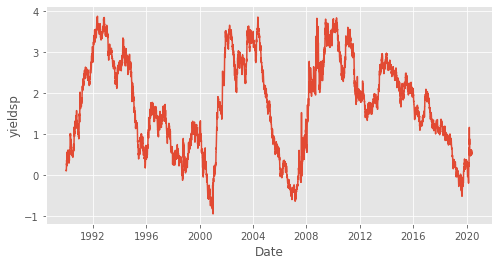

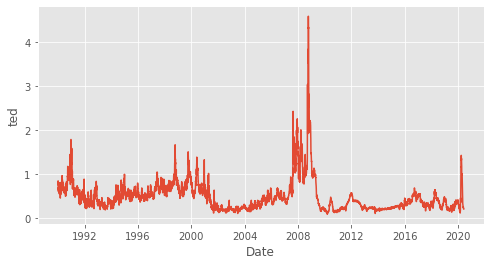

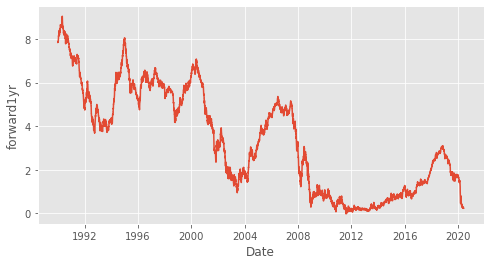

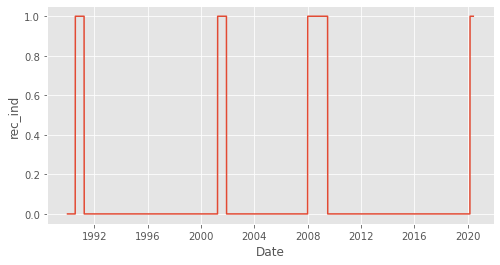

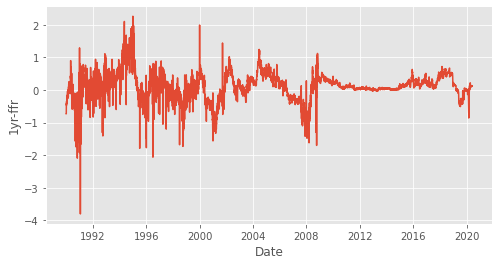

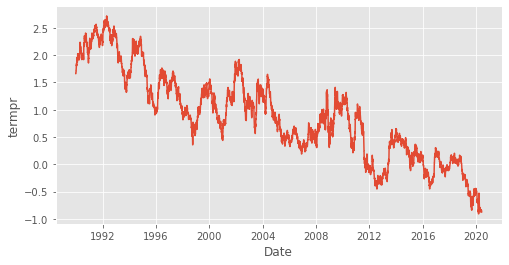

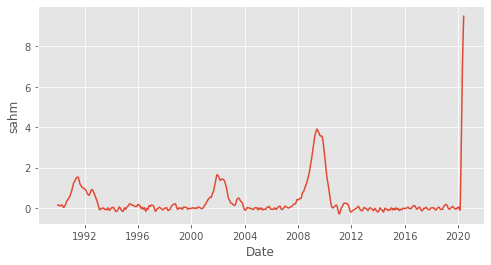

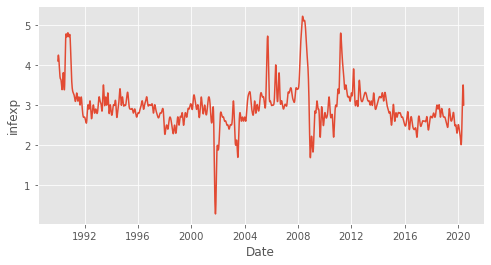

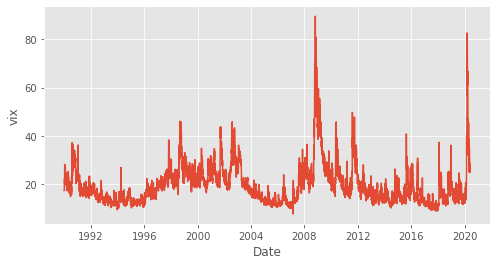

In [283]:
# plots each column of the dataset

def plot_data(col):
    plt.figure(figsize = (8,4))
    plt.plot(yield_d[col])
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()
    
for col in yield_d.columns:
    plot_data(col)

In [284]:
stat_list1 = stat1[['forward1yr_diff', 'termpr_diff','yieldsp_diff', 'sahm_diff']]

# ADF Test on the first differenced values each column
for name, column in stat_list1.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "forward1yr_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -54.474
  No. of Lags Chosen    = 2
  Critical Value 1%     = -3.431
  Critical Value 5%     = -2.862
  Critical Value 10%    = -2.567
 => P-Value = 0.0. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "termpr_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -54.1568
  No. of Lags Chosen    = 2
  Critical Value 1%     = -3.431
  Critical Value 5%     = -2.862
  Critical Value 10%    = -2.567
 => P-Value = 0.0. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "yieldsp_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. N

Variables stationary: ted, rec_ind, 1yr-ffr, vix, infexp

Variables that need first differencing: forward1yr, termpr, yieldsp, sahm

### Plot of Stationary Variables


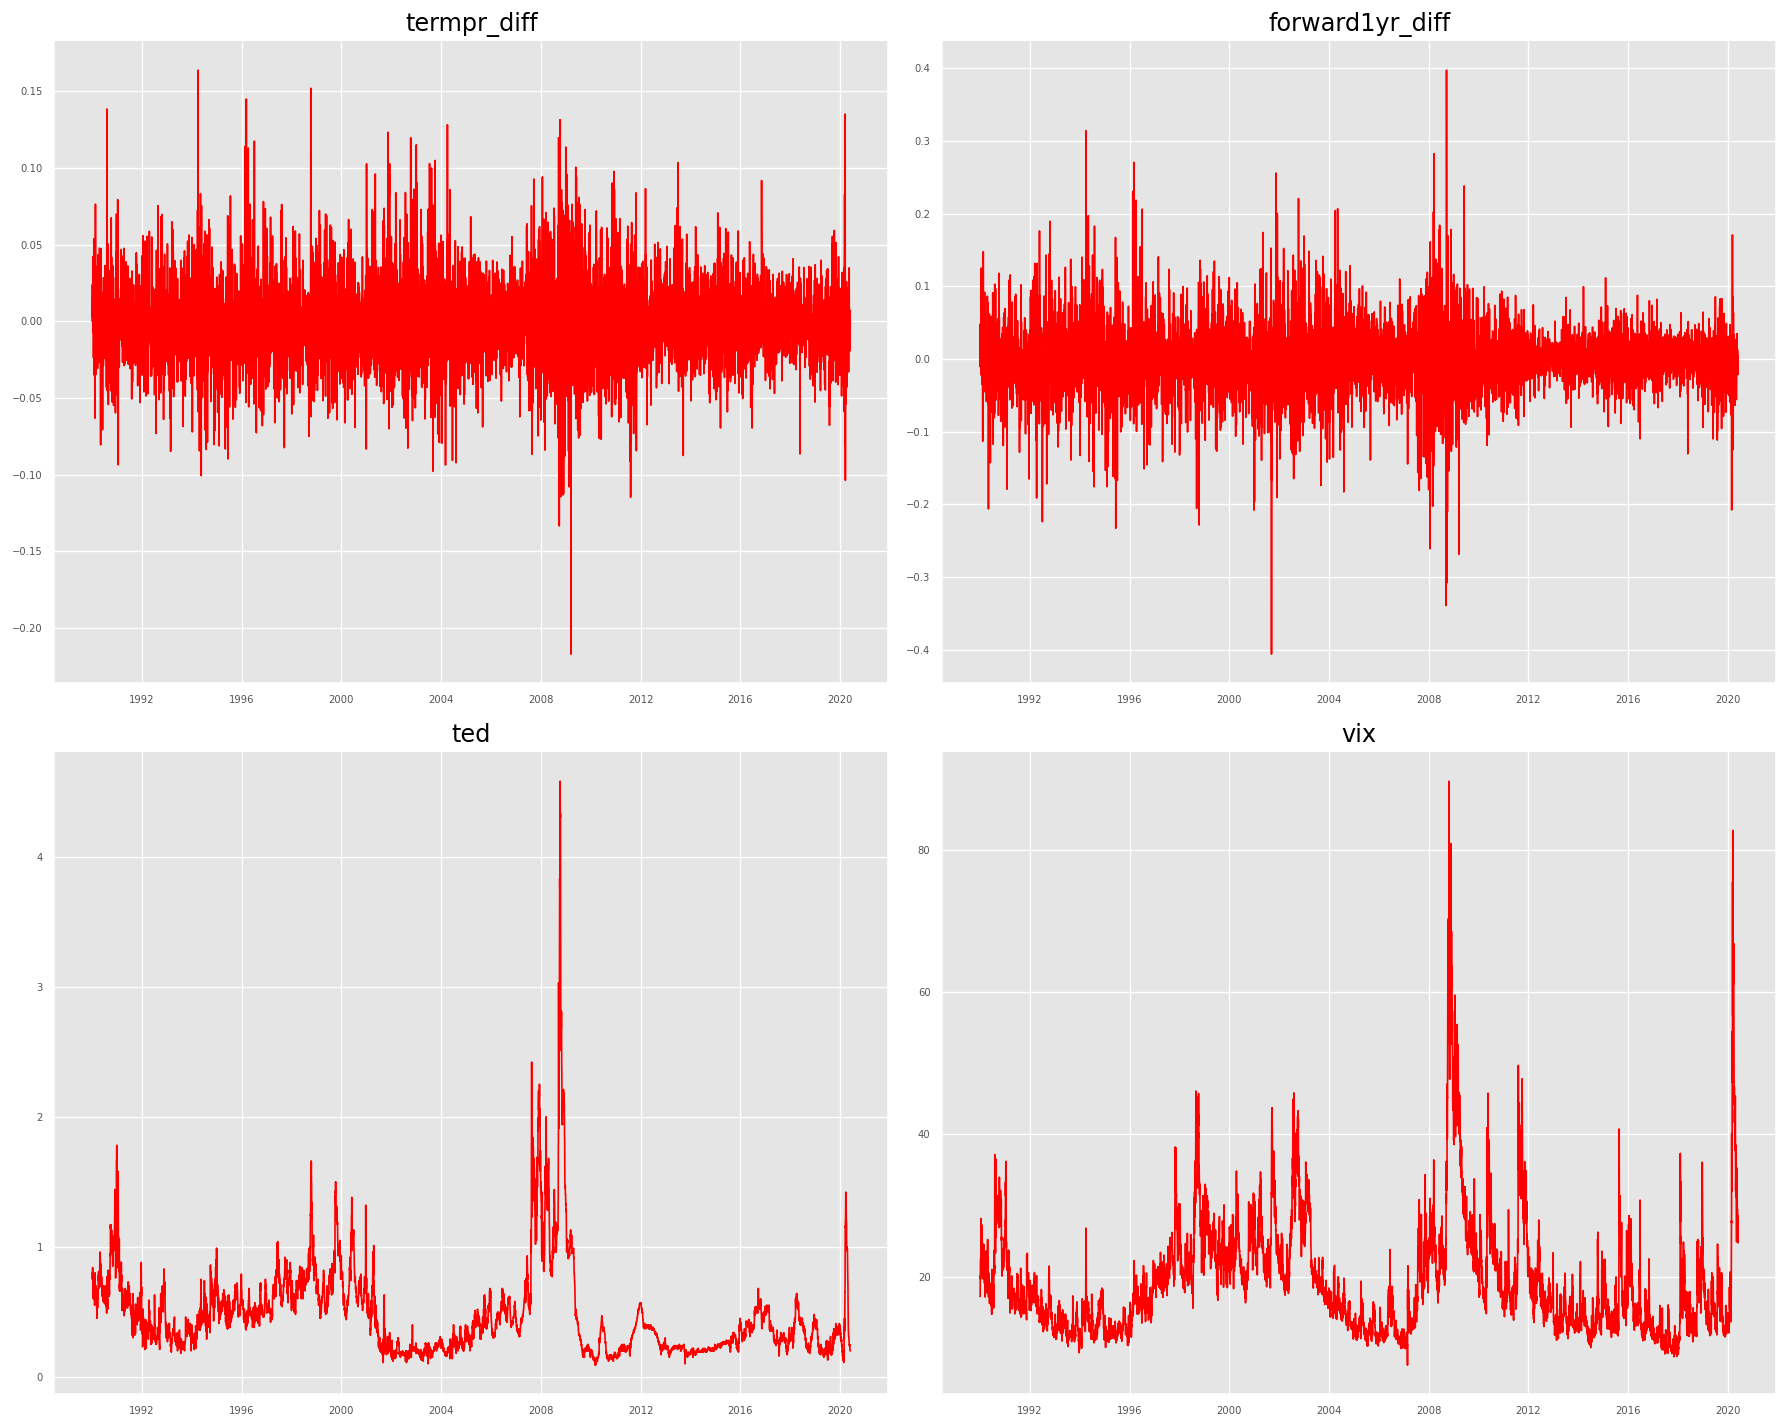

In [285]:
stat = stat1[['termpr_diff', 'forward1yr_diff', 'ted', 'vix']]

fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(15, 12))

for i, ax in enumerate(axes.flatten()):
    d = stat[stat.columns[i]]
    ax.plot(d, color='red', linewidth=1)
    
    # Decorations
    
    ax.set_title(stat.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout();

## ARIMAX

ARIMA can handle 2 types of non-stationarity: hidden trend (linear, polynomial, seasonals, etc.), and unit roots.

Differencing removes any type of polynomial trend. A higher-degree polynomial requires more number of differencing to stationarize the series.

The equation can have more than one exogenous variable and/or lags of exogenous variables in the above equation.

The dependent variable is a univariate time series.

The model cannot be used for forecasting 𝑦_𝑡+ℎ unless one has the future values of the independent variable 𝑥𝑡+ℎ 
available, or has a separate model for predicting 𝑥_𝑡+ℎ.

The model is estimated using maximum likelihood (slow), often using a state space representation.
Allowing for both AR and MA terms offers a parsimonious representation of the process.

In [286]:
# Train-test split : last 5 percent of the observations are in the test set
train, test = np.split(stat1, [int(.95 *len(stat1))])

#data_list = yield_d[list(yield_d.columns)]

exog_train = train[['ted', 'rec_ind', '1yr-ffr', 'vix', 'termpr_diff', 'forward1yr_diff', 'infexp']]
exog_test = test[['ted', 'rec_ind', '1yr-ffr', 'vix', 'termpr_diff','forward1yr_diff', 'infexp']]

# fit model in the train set

model = ARIMA(train['yieldsp'],exog = exog_train, order=(1,0,1)) 

# disp = 0: turns off the debug info about the fit of the ARIMA model
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                yieldsp   No. Observations:                10553
Model:                     ARMA(1, 1)   Log Likelihood               20886.381
Method:                       css-mle   S.D. of innovations              0.033
Date:                Sun, 02 Aug 2020   AIC                         -41750.762
Time:                        22:13:31   BIC                         -41670.856
Sample:                    01-02-1990   HQIC                        -41723.787
                         - 11-23-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.1775      0.597      1.972      0.049       0.007       2.348
ted                 0.4664      0.008     57.431      0.000       0.450       0.482
rec_ind            -0.0088      

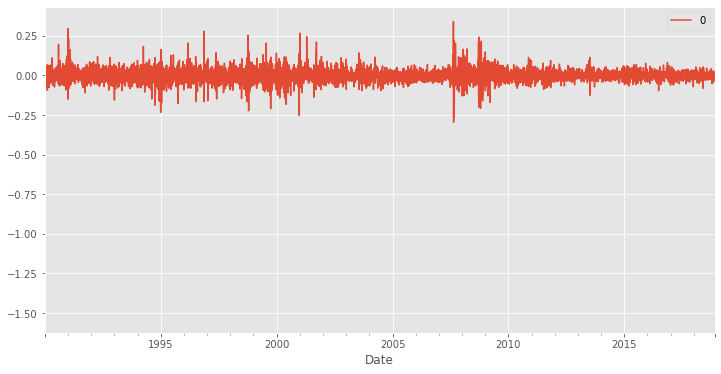

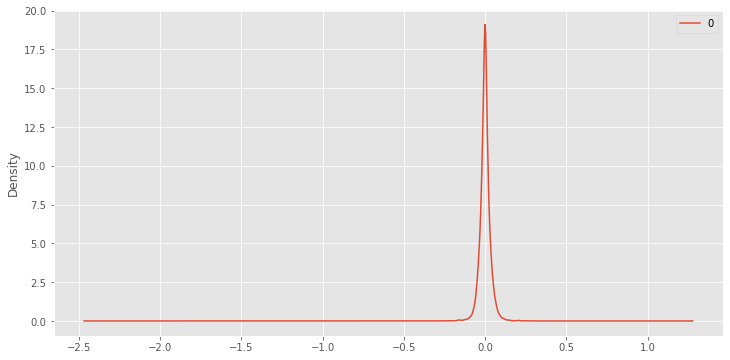

                  0
count  10553.000000
mean       0.000074
std        0.036599
min       -1.531786
25%       -0.015625
50%       -0.000201
75%        0.014837
max        0.341207


In [287]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

# Density plot
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [303]:
# fit SARIMAX in the whole model, then compare forecats from the train with test set
exog = stat1[['ted', 'rec_ind', '1yr-ffr', 'vix', 'termpr_diff', 'forward1yr_diff', 'infexp']]

mod = sm.tsa.statespace.SARIMAX(stat1['yieldsp'], exog = exog,
                                order = (2, 1, 2),
                                seasonal_order = (0, 0, 0, 0),
                                enforce_stationarity = True,
                                enforce_invertibility = True)

results = mod.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                yieldsp   No. Observations:                11109
Model:               SARIMAX(2, 1, 2)   Log Likelihood               22172.534
Date:                Sun, 02 Aug 2020   AIC                         -44321.069
Time:                        22:58:15   BIC                         -44233.284
Sample:                    01-02-1990   HQIC                        -44291.509
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ted                 0.4632      0.002    196.263      0.000       0.459       0.468
rec_ind            -0.0057      0.018     -0.310      0.757      -0.042       0.030
1yr-ffr             0.0174      

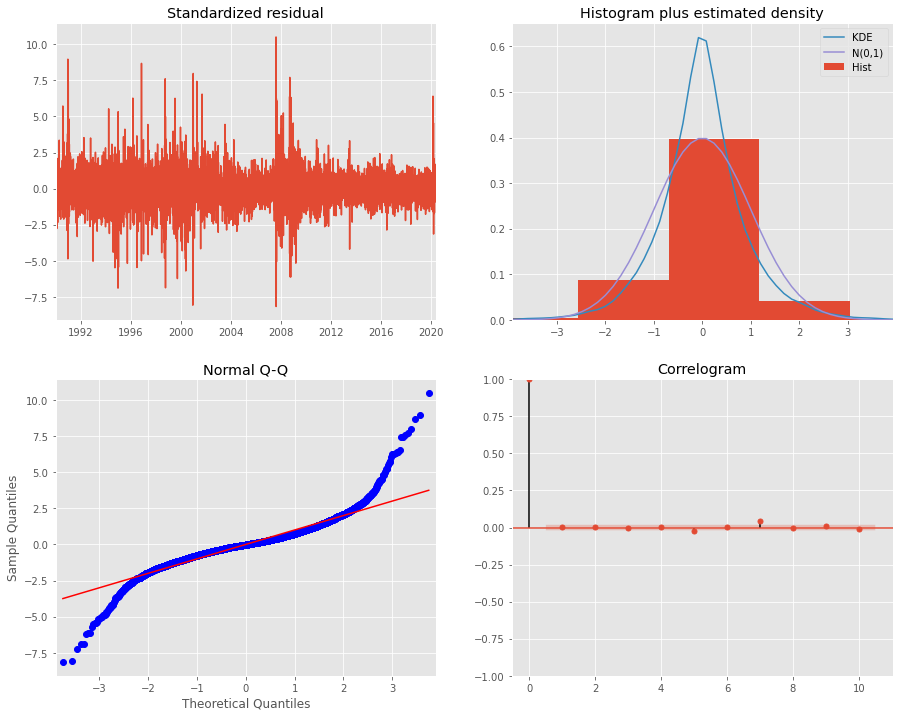

In [304]:
# run model diagnostics to ensure that none of the assumptions made by the model have been violated.
results.plot_diagnostics(figsize=(15, 12))
plt.show()

We have to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean :

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

1. In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.


2. The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.


3. The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

In [305]:
train.tail(1).index # last date on train set 

DatetimeIndex(['2018-11-23'], dtype='datetime64[ns]', name='Date', freq=None)

In [306]:
test.head(1).index # first date on test set

DatetimeIndex(['2018-11-24'], dtype='datetime64[ns]', name='Date', freq=None)

In [307]:
test.tail()

yieldsp  ted  forward1yr  rec_ind  1yr-ffr  termpr      sahm  \
Date                                                                       
2020-05-28     0.55  0.2      0.2611      1.0     0.12 -0.8489  9.258933   
2020-05-29     0.51  0.2      0.2400      1.0     0.12 -0.8681  9.320238   
2020-05-30     0.52  0.2      0.2393      1.0     0.12 -0.8703  9.380838   
2020-05-31     0.52  0.2      0.2393      1.0     0.12 -0.8703  9.440753   
2020-06-01     0.52  0.2      0.2393      1.0     0.12 -0.8703  9.500000   

              infexp        vix  forward1yr_diff  termpr_diff  yieldsp_diff  \
Date                                                                          
2020-05-28  3.231791  28.590000           0.0027       0.0034          0.02   
2020-05-29  3.181334  27.510000          -0.0211      -0.0192         -0.04   
2020-05-30  3.125967  25.372422          -0.0007      -0.0022          0.01   
2020-05-31  3.065565  24.753633           0.0000       0.0000          0.00   
2020-06-01  3.000000  28.230000           0.0000       0.0000          0.00   

            sahm_diff  
Date                   
2020-05-28   0.062027  
2020-05-29   0.061305  
2020-05-30   0.060600  
2020-05-31   0.059914  
2020-06-01   0.059247

In [308]:
# get predictions from the above model
#  compare predicted to real values of the time series => help us understand the accuracy of our forecasts
#  dynamic=False argument ensures that we produce one-step ahead forecasts, 
# => forecasts at each point are generated using the full history up to that point.
# compute the forecasts and confidence intervals start from the first date in the test set


pred_dynamic = results.get_prediction(start = pd.to_datetime('2018-11-24'), dynamic = True, 
                                      exog = exog_test, full_results = True)
                                      
pred_dynamic_ci = pred_dynamic.conf_int(exog = exog_test)
pred_dynamic_ci.head()

lower yieldsp  upper yieldsp
2018-11-24       0.584206       0.713065
2018-11-25       0.539955       0.757849
2018-11-26       0.506375       0.794078
2018-11-27       0.479156       0.819390
2018-11-28       0.457988       0.842271

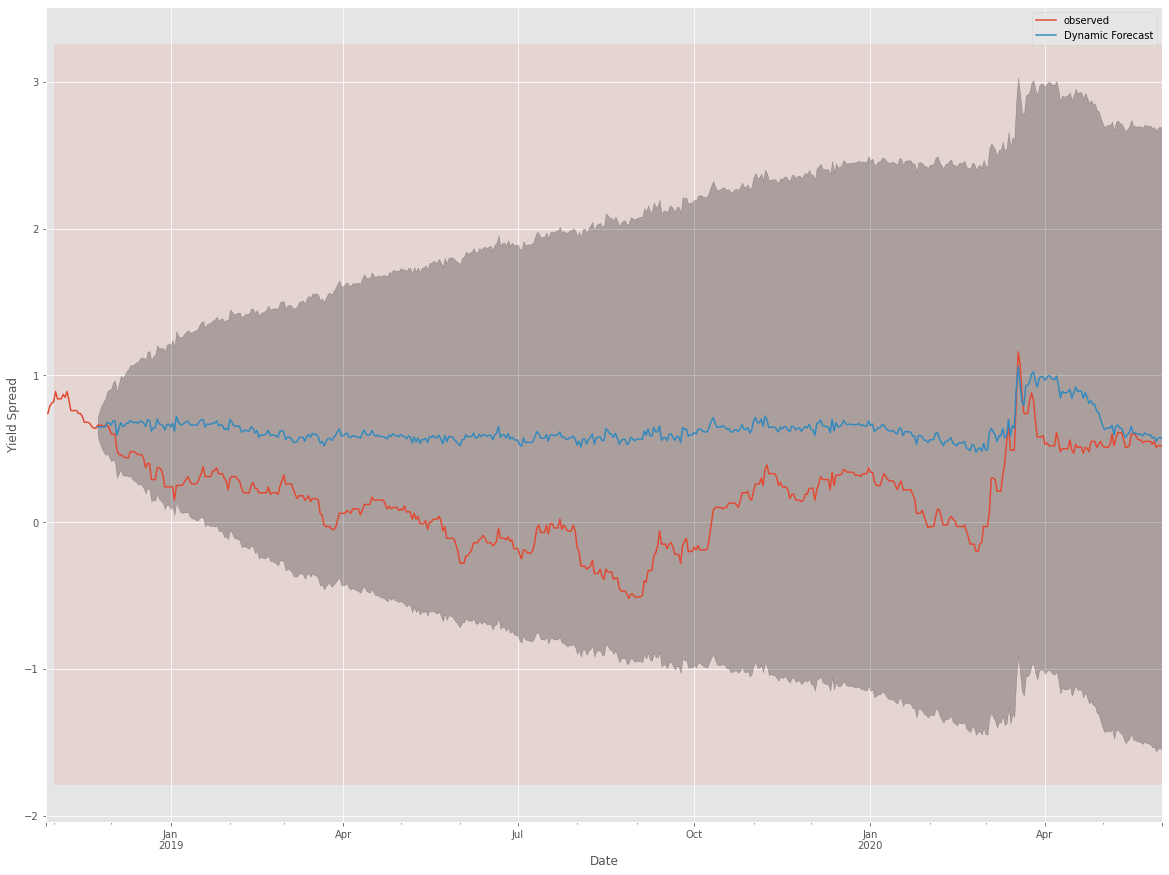

In [309]:
# plot the real and forecasted values of the yield spread 
# zoomed in on the end of the time series by slicing the date index.

ax = stat1['yieldsp']['2018-10-28':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax = ax)

# test set begins from 2012-09-30
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-11-01'), stat1['yieldsp'].index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Yield Spread')

plt.legend()
plt.show()

In [310]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = stat1['yieldsp']['2018-11-24':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 0.2831


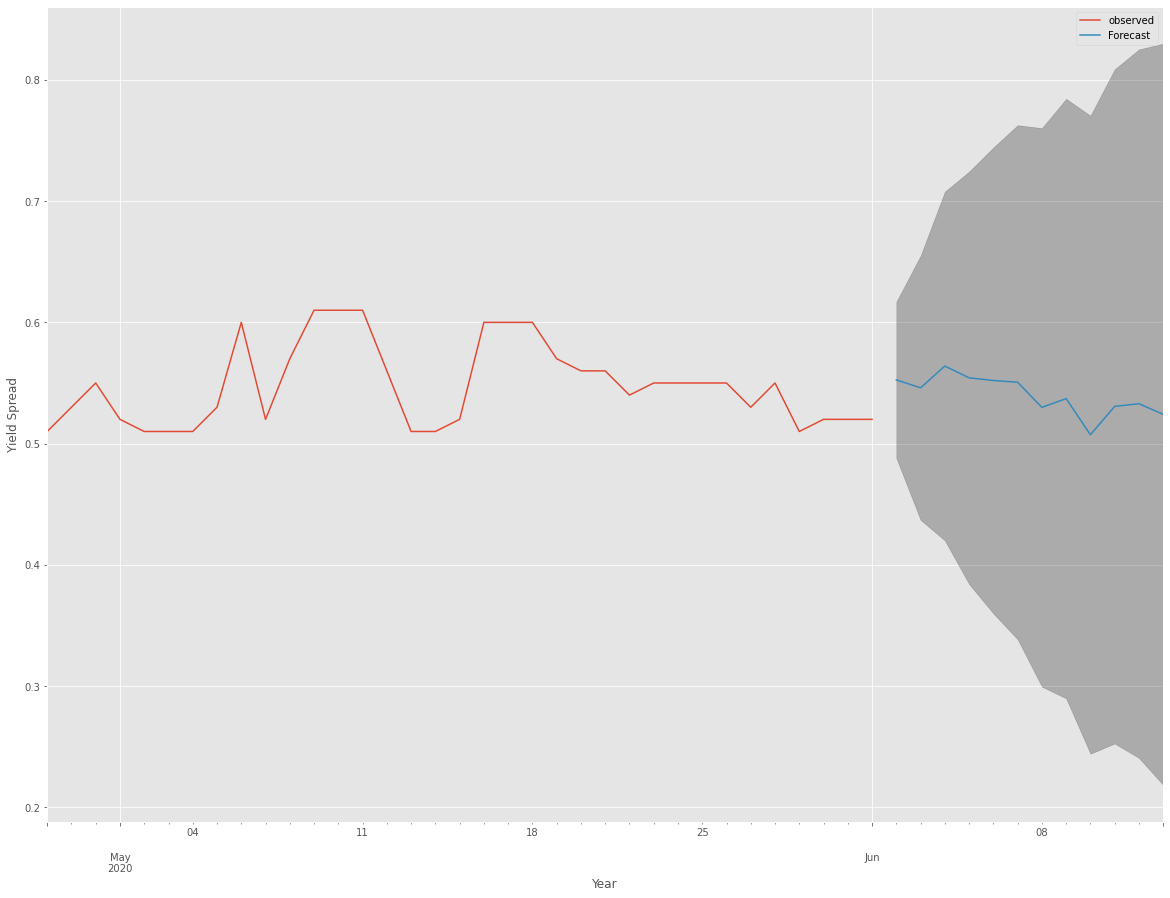

In [311]:
# Get forecast 12 steps ahead in future
pred_uc = results.get_forecast(steps= 12, exog = exog_test.tail(12))

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int(exog = exog_test.tail(12))

ax = stat1['yieldsp']['2020-04-28':].plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Yield Spread')

plt.legend()
plt.show()

In [312]:
pred_ci

lower yieldsp  upper yieldsp
2020-06-02       0.488108       0.616966
2020-06-03       0.437075       0.654970
2020-06-04       0.420108       0.707811
2020-06-05       0.384140       0.724375
2020-06-06       0.359924       0.744207
2020-06-07       0.338582       0.762629
2020-06-08       0.299581       0.760204
2020-06-09       0.289870       0.784363
2020-06-10       0.244257       0.770409
2020-06-11       0.252696       0.808703
2020-06-12       0.240759       0.825102
2020-06-13       0.218492       0.829861

In [313]:
# Does ted spread granger cause yield spread?
grangercausalitytests(stat1[['yieldsp', 'ted']], maxlag=5);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3038  , p=0.0381  , df_denom=11105, df_num=1
ssr based chi2 test:   chi2=4.3049  , p=0.0380  , df=1
likelihood ratio test: chi2=4.3041  , p=0.0380  , df=1
parameter F test:         F=4.3038  , p=0.0381  , df_denom=11105, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.8641  , p=0.0010  , df_denom=11102, df_num=2
ssr based chi2 test:   chi2=13.7345 , p=0.0010  , df=2
likelihood ratio test: chi2=13.7260 , p=0.0010  , df=2
parameter F test:         F=6.8641  , p=0.0010  , df_denom=11102, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=14.7529 , p=0.0000  , df_denom=11099, df_num=3
ssr based chi2 test:   chi2=44.2867 , p=0.0000  , df=3
likelihood ratio test: chi2=44.1987 , p=0.0000  , df=3
parameter F test:         F=14.7529 , p=0.0000  , df_denom=11099, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=13.1844 

Since the p-values at lags from 1 to 5 lags are very low, we reject the null hypothesis. So, the ted spread Granger causes the yield spread. The p-values aee lower than the significance level even at lags greater than 5. So, the past values of ted spread  have a statistically significant effect on the current value of yield spread. Here, we consider the past values of ted spread as regressors.

In [315]:
# granger causality for all variables in the train set
stat_train = train[['termpr_diff', 'forward1yr_diff', 'ted', 'vix', 'yieldsp', 'yieldsp_diff', 'rec_ind', 'infexp']]

maxlag=5

test = 'ssr-chi2test'

def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]

    return dataset

grangers_causality_matrix(stat_train, variables = stat_train.columns)  

termpr_diff_x  forward1yr_diff_x   ted_x   vix_x  \
termpr_diff_y             1.0000             0.0000  0.0000  0.1120   
forward1yr_diff_y         0.0000             1.0000  0.0004  0.0160   
ted_y                     0.0000             0.0000  1.0000  0.0000   
vix_y                     0.0000             0.0000  0.0000  1.0000   
yieldsp_y                 0.0000             0.0000  0.0000  0.0000   
yieldsp_diff_y            0.0000             0.0000  0.0000  0.0000   
rec_ind_y                 0.3619             0.4692  0.0002  0.0135   
infexp_y                  0.0122             0.0000  0.0000  0.0000   

                   yieldsp_x  yieldsp_diff_x  rec_ind_x  infexp_x  
termpr_diff_y         0.0000          0.0000     0.0005    0.0388  
forward1yr_diff_y     0.0000          0.0000     0.0049    0.0021  
ted_y                 0.0000          0.0000     0.0038    0.0003  
vix_y                 0.0158          0.0140     0.0000    0.0206  
yieldsp_y             1.0000          0.0000     0.0000    0.2252  
yieldsp_diff_y        0.0043          1.0000     0.0000    0.1949  
rec_ind_y             0.0424          0.0957     1.0000    0.0004  
infexp_y              0.0010          0.1307     0.0000    1.0000

The row are the response (y) and the columns are the predictor series (x).

p-value = 0.1118 => tests if yieldsp granger causes vix => since the p-value is larger than the 0.05 significance level, we fail to reject the null hypothesis => yieldsp does not granger causes vix

p-values = 0 under rows yieldsp and yieldsp_diff
since p-value = 0.0957 => fail to reject the null hypothesis => yield_diff doesn't granger cause rec_ind


## Vector Autoregression (VAR)

The dependent variable is a multivariate time series.

The model can be used for forecasting all components of 𝑧𝑡+ℎ, e.g. for 𝑧=(𝑦,𝑥)′. Given data up to and including time 𝑡, forecasts for time 𝑡+1 are straightforward to obtain; forecasts for 𝑡+ℎ where ℎ>1 can be obtained iteratively.

The model can be estimated using OLS or GLS (fast).

Lack of MA terms may (or may not) require large AR order to approximate the process well, and large AR order means a large number of parameters to be estimated and thus high estimation variance. Fortunately, regularization (shrinkage) applies pretty straightforwardly to VAR models (unlike ARMAX), so the variance can be tamed.

I have implemented Akaike’s Information Criteria (AIC) through the VAR (p) to determine the lag order value. In the fit function, I have passed a maximum number of lags and the order criterion to use for order selection.

In [316]:
# use stationary variables only for VAR
stat_train = train[['yieldsp_diff','termpr_diff', 'forward1yr_diff', 'ted', 'vix', 'rec_ind', 'infexp']]

### FIND BEST VAR ORDER ###

from statsmodels.tsa.api import VAR

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,50):
    model = VAR(endog=stat_train.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('Best Order', best_order, 'BEST AIC:', best_aic)

Best Order 39 BEST AIC: -59.668663340021695


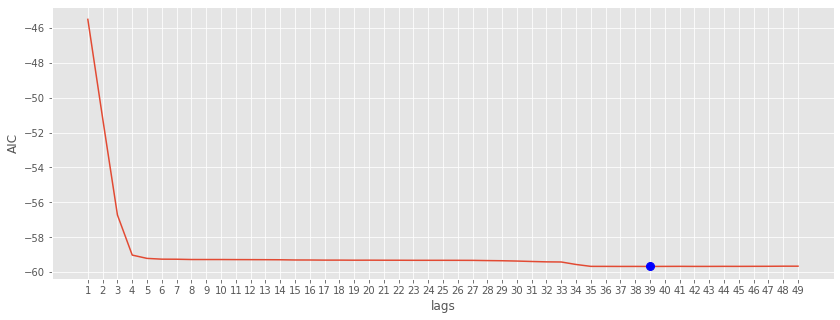

In [317]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="blue")
plt.xticks(range(len(AIC)), range(1,50))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [339]:
# fit the VAR model on training set and then used the fitted model to forecast the next 15 observations.
# compare these forecasts with the actual present in test data. 

mod = VAR(stat_train)
res = mod.fit(best_order) 
#res.summary() => too long results as there are 39 lags

## Durbin-Watson Statistic

Durbin-Watson Statistic is related to related to auto correlation.

The Durbin-Watson statistic will always have a value between 0 and 4. A value of 2.0 means that there is no auto-correlation detected in the sample. Values from 0 to less than 2 indicate positive auto-correlation and values from 2 to 4 indicate negative auto-correlation. A rule of thumb is that test statistic values in the range of 1.5 to 2.5 are relatively normal. Any value outside this range could be a cause for concern.

In [340]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(res.resid)

for col, val in zip(stat_train.columns, out):
    print((col), ':', round(val, 2))

yieldsp_diff : 2.0
termpr_diff : 2.0
forward1yr_diff : 2.0
ted : 2.0
vix : 2.0
rec_ind : 2.0
infexp : 2.0


Since there is no auto-correlation (2.0); then, we can forecast. 

## Prediction

In order to forecast, the VAR model expects up to the lag order number of observations from the past data. This is because, the terms in the VAR model are essentially the lags of the various time series in the data-set, so we need to provide as many of the previous values as indicated by the lag order used by the model.

In [341]:
# Get the lag order
lag_order = res.k_ar

# Train-test split : last 10 percent of the observations are in the test set (from before)
train, test = np.split(stat1, [int(.95 *len(stat1))])

stat_test = test[['yieldsp_diff','termpr_diff', 'forward1yr_diff', 'ted', 'vix', 'rec_ind', 'infexp']]


# Input data for forecasting
input_data = stat_test.values[-lag_order:]

# VAR forecasts for the test set
pred = res.forecast(y=input_data, steps = len(test))
pred1 = pd.DataFrame(pred, index=stat_test.index, columns= stat_test.columns + '_pred')
pred1.head()

yieldsp_diff_pred  termpr_diff_pred  forward1yr_diff_pred  \
Date                                                                    
2018-11-24           0.008064          0.002167              0.000629   
2018-11-25           0.012033         -0.000446             -0.004098   
2018-11-26           0.000826         -0.003654             -0.008241   
2018-11-27           0.004130         -0.007134             -0.014483   
2018-11-28           0.014582         -0.003475             -0.014044   

            ted_pred   vix_pred  rec_ind_pred  infexp_pred  
Date                                                        
2018-11-24  0.206755  29.792587      0.990995     2.929197  
2018-11-25  0.216613  29.576141      0.983162     2.853145  
2018-11-26  0.228080  29.700621      0.970618     2.771891  
2018-11-27  0.247958  29.950270      0.959333     2.685531  
2018-11-28  0.268256  30.029959      0.949355     2.594208

In [342]:
merge0 = pd.merge(test['yieldsp'], pred1['yieldsp_diff_pred'].to_frame(), how='inner', 
                  left_index=True, right_index=True)
merge0.head()

yieldsp  yieldsp_diff_pred
Date                                  
2018-11-24     0.66           0.008064
2018-11-25     0.66           0.012033
2018-11-26     0.66           0.000826
2018-11-27     0.65           0.004130
2018-11-28     0.66           0.014582

In [343]:
# inverting transformation
def invert_diff(history, yhat, interval=1):
    return yhat + history[-interval]

invert0 = invert_diff(merge0['yieldsp'], merge0['yieldsp_diff_pred'], 1).to_frame()
invert0.rename(columns={'yieldsp_diff_pred':'invert_yieldsp_var'}, inplace=True)
merge_invert0 = pd.merge(merge0, invert0, how='inner', left_index=True, 
                         right_index=True).drop(['yieldsp_diff_pred'], axis = 1)
merge_invert0.tail()

yieldsp  invert_yieldsp_var
Date                                   
2020-05-28     0.55            0.518207
2020-05-29     0.51            0.518223
2020-05-30     0.52            0.518233
2020-05-31     0.52            0.518239
2020-06-01     0.52            0.518238

In [344]:
error = mean_squared_error(merge_invert0['yieldsp'], merge_invert0['invert_yieldsp_var'])
rmse = sqrt(error)
print('RMSE: %.5f' % rmse)

RMSE: 0.46614


In [345]:
# Evaluation: # forecast period is 5 year=> forecasting upto 5 years into the future
fevd = res.fevd(5)
fevd.summary()

FEVD for yieldsp_diff
     yieldsp_diff  termpr_diff  forward1yr_diff       ted       vix   rec_ind    infexp
0        1.000000     0.000000         0.000000  0.000000  0.000000  0.000000  0.000000
1        0.997920     0.001095         0.000151  0.000062  0.000643  0.000127  0.000003
2        0.995905     0.001251         0.000158  0.001449  0.000810  0.000409  0.000019
3        0.992539     0.002694         0.000847  0.001468  0.001155  0.001240  0.000056
4        0.988247     0.002794         0.003572  0.001514  0.002366  0.001446  0.000061

FEVD for termpr_diff
     yieldsp_diff  termpr_diff  forward1yr_diff       ted       vix   rec_ind    infexp
0        0.597115     0.402885         0.000000  0.000000  0.000000  0.000000  0.000000
1        0.608222     0.390649         0.000826  0.000002  0.000063  0.000232  0.000006
2        0.608901     0.389065         0.000965  0.000253  0.000385  0.000278  0.000154
3        0.609136     0.387575         0.000970  0.000456  0.000504  0.00115

Variance decomposition shows how much a shock to one variable (e.g: vix, ted, etc) impacts the variance of the forecast error of a different one (e.g: forward1yr, rec_ind, yieldsp, etc). So, in the short run, i.e. in the same period, the yieldsp_diff  explains 57.43% of the variance in forecast error of termpr_diff,indicating that it is strongly endogenous as it has a strong influence on termpr_diff.  ted, vix, rec_ind are strongly exogenous as they only weakly influence in predicting the termpr_diff in the present. termpr_diff itself explains 42.56 percent of variance in the its error.

However, in the long run, the influence of termpr_diff in explaining the variance in its forecast error has diminished marginally from 42.56 to 41.1 percent, whereas yieldsp_diff and fed_fundsR has an incremental influence, as its affect rises from 57.43 to 58.5 percent in the short in the earlier periods in the short run.

Time series models for VAR are usually based on applying VAR to stationary series with first differences to original series and because of that, there is always a possibility of loss of information about the relationship among integrated series.

Therefore, differencing the series to make them stationary is one solution, but at the cost of ignoring possibly important (“long run”) relationships between the levels. A better solution is to test whether the levels regressions are trustworthy (“cointegration”.) The usual approach is to use Johansen’s method for testing whether or not cointegration exists. If the answer is “yes” then a vector error correction model (VECM), which combines levels and differences, can be estimated instead of a VAR in levels.

## Impulse Response Functions

In the context of a VAR model, the IRFs trace out the time path of the effects of an exogenous shock to one (or more) of the endogenous variables on some or all of the other variables in a VAR system.

https://learning.oreilly.com/library/view/essentials-of-time/9780128134108/xhtml/chp003_b.xhtml

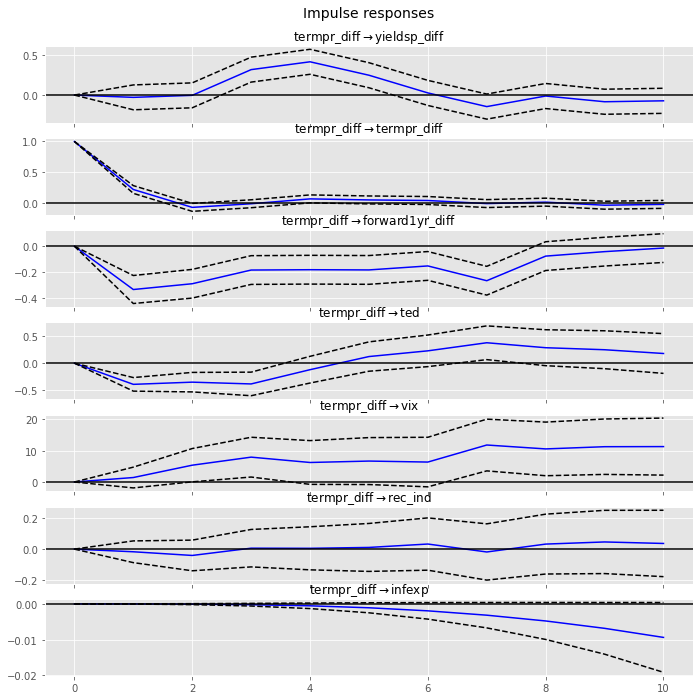

In [346]:
irf1 = res.irf(10)
irf1.plot(impulse='termpr_diff');

## Johansen Cointegration and VECM

The process of estimating the VECM consists roughly of the three following steps, the confusing one of which is for me the first one:

1. Specification and estimation of a VAR model for the integrated multivariate time series

2. Calculate likelihood ratio tests to determine the number of cointegration relations

3. After determining the number of cointegrations, estimate the VECM

In the first step one estimates a VAR model with appropriate number of lags (using the usual goodness of fit criteria) and then checks if the residuals correspond to the model assumptions, namely the absence of serial correlation and heteroscedasticity and that the residuals are normally distributed. So, one checks if the VAR model appropriately describes the multivariate time series, and one proceeds to further steps only if it does.

In order to fit a VECM model, we need to determine the number of co-integrating relationships using a VEC rank test.

Using the trace statistic method, the test statistic of 38.25 is greater than the critical values, so we reject the null hypothesis of at most one co-integrating vector. The maximum eigenvalue statistic method reveals similar results - test statistics > critical value 

In theory VECM is just a representation of cointegrated VAR. This representation is courtesy of Granger's representation theorem. So if you have cointegrated VAR it has VECM representation and vice versa.

In practice you need to determine the number of cointegrating relationships. When you fix that number you restrict certain coefficients of VAR model. So advantage of VECM over VAR (which you estimate ignoring VECM) is that the resulting VAR from VECM representation has more efficient coefficient estimates.

In [347]:
# Trace method of cointegration
vec_rank = select_coint_rank(stat_train, det_order = 1, k_ar_diff = 1, method = 'trace', signif=0.01)
print(vec_rank.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   7      1.348e+04          150.1
  1   7          7868.          117.0
  2   7          4241.          87.77
  3   7          1578.          62.52
  4   7          251.1          41.08
  5   7          79.93          23.15
  6   7          16.26          6.635
-------------------------------------


In [348]:
# Max eigen method of cointegration
vec_rank1 = select_coint_rank(stat_train, det_order = 1, k_ar_diff = 1, method = 'maxeig', signif=0.01)
print(vec_rank1.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          5616.          55.82
  1   2          3626.          49.41
  2   3          2664.          42.86
  3   4          1327.          36.19
  4   5          171.2          29.26
  5   6          63.67          21.75
  6   7          16.26          6.635
-------------------------------------


In [349]:
vecm = VECM(endog = stat_train, k_ar_diff = 9, coint_rank = 5, deterministic = 'ci')
vecm_fit = vecm.fit()
pred_vecm = pd.DataFrame(vecm_fit.predict(steps=len(stat_test)),index=stat_test.index, 
                         columns= stat_test.columns + '_pred' )
pred_vecm.head()

yieldsp_diff_pred  termpr_diff_pred  forward1yr_diff_pred  \
Date                                                                    
2018-11-24           0.005374         -0.001019             -0.002693   
2018-11-25           0.002270         -0.001481             -0.004756   
2018-11-26           0.007439          0.000573             -0.001833   
2018-11-27           0.003016          0.001357             -0.000100   
2018-11-28          -0.002228         -0.000469             -0.000653   

            ted_pred   vix_pred  rec_ind_pred  infexp_pred  
Date                                                        
2018-11-24  0.337652  21.649511      0.000308     2.709378  
2018-11-25  0.341445  21.370501     -0.000308     2.707504  
2018-11-26  0.346305  21.254696     -0.000152     2.705798  
2018-11-27  0.351040  21.223370     -0.000557     2.704258  
2018-11-28  0.355455  21.070909     -0.000774     2.702881

In [350]:
# inverting transformation
def invert_diff(history, yhat, interval=1):
    return yhat + history[-interval]

invert = invert_diff(test['yieldsp'], pred_vecm['yieldsp_diff_pred'], 1).to_frame()
invert.rename(columns={'yieldsp_diff_pred':'invert_yieldsp_vecm'}, inplace=True)
merge_invert = pd.merge(merge_invert0, invert, how='inner', left_index=True, right_index=True)
merge_invert.tail()

yieldsp  invert_yieldsp_var  invert_yieldsp_vecm
Date                                                        
2020-05-28     0.55            0.518207             0.519423
2020-05-29     0.51            0.518223             0.519423
2020-05-30     0.52            0.518233             0.519423
2020-05-31     0.52            0.518239             0.519423
2020-06-01     0.52            0.518238             0.519423

In [351]:
error = mean_squared_error(merge_invert['yieldsp'], merge_invert['invert_yieldsp_vecm'])
rmse = sqrt(mse)
print('RMSE: %.5f' % rmse)

RMSE: 0.53211


## VARMAX

VAR(2) and VARMAX(2, 0) are theoretically identical models, however in statsmodels the VAR(2) model is fit via conditional maximum likelihood (i.e. least squares) and the VARMAX(2, 0) model is fit via exact maximum likelihood.

You will generally not get the same coefficients, for two reasons:
(1) Conditional MLE is only asymptotically the same as exact MLE
(2) The maximum likelihood estimates in VARMAX are found numerically, and there may be difficulties finding the maximum and / or there may be numerical noise.

Convergence warnings in VARMAX are common, because vector autoregressions typically have poor identification for many of the parameters.

Advantage - VARMA is closed w.r.t linear transformation => linear transformation finite order VARMA has a finite order VARMA representation.
https://core.ac.uk/download/pdf/6263631.pdf


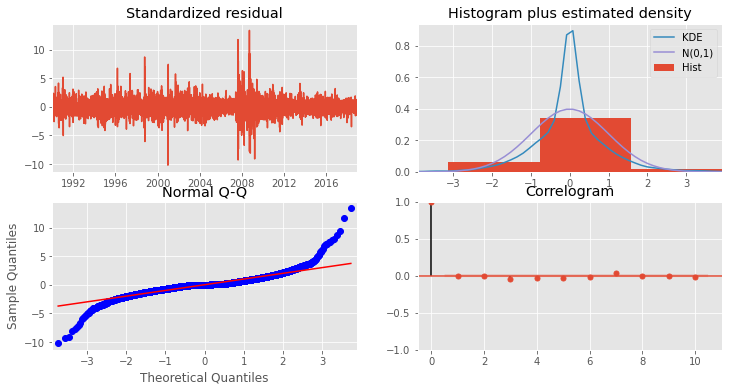

In [352]:
model = sm.tsa.VARMAX(stat_train, order=(2, 2))
model_result = model.fit(maxiter=5, disp=False)
model_result.plot_diagnostics()
plt.show()

In [353]:
vfor = model_result.forecast(steps=len(test))
varmax_forecast = pd.DataFrame(vfor['yieldsp_diff']).rename(columns={'yieldsp_diff':'yieldsp_diff_pred'})

invert1 = invert_diff(test['yieldsp'], varmax_forecast['yieldsp_diff_pred'], 1).to_frame()
invert1.rename(columns={'yieldsp_diff_pred':'invert_yieldsp_varmax'}, inplace=True)
merge_invert1 = pd.merge(test['yieldsp'].to_frame(), invert1, how='inner', left_index=True, right_index=True)
merge_invert1.head()

yieldsp  invert_yieldsp_varmax
Date                                      
2018-11-24     0.66               0.519504
2018-11-25     0.66               0.519937
2018-11-26     0.66               0.520601
2018-11-27     0.65               0.520638
2018-11-28     0.66               0.520578

In [354]:
merge_invert2 = pd.merge(merge_invert, merge_invert1['invert_yieldsp_varmax'], how='inner', left_index=True, 
                         right_index=True)
merge_invert2.head()

yieldsp  invert_yieldsp_var  invert_yieldsp_vecm  \
Date                                                           
2018-11-24     0.66            0.528064             0.525374   
2018-11-25     0.66            0.532033             0.522270   
2018-11-26     0.66            0.520826             0.527439   
2018-11-27     0.65            0.524130             0.523016   
2018-11-28     0.66            0.534582             0.517772   

            invert_yieldsp_varmax  
Date                               
2018-11-24               0.519504  
2018-11-25               0.519937  
2018-11-26               0.520601  
2018-11-27               0.520638  
2018-11-28               0.520578

In [355]:
error = mean_squared_error(merge_invert2['yieldsp'], merge_invert2['invert_yieldsp_varmax'])
rmse = sqrt(mse)
print('RMSE: %.5f' % rmse)

RMSE: 0.53211


In [356]:
# line plot shows that compares the actual yieldsp with rolling forecast predictions from leveled and diff ARIMA
fig_vecm = merge_invert.iplot(asFigure=True, kind='scatter', xTitle='Date', 
                                 yTitle='Yield Spread (Percent)')
fig_vecm.update_layout(
    title={
        'text': 'Predicted and Actual Yield Spread from VAR, VECM and VARMX',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig_vecm.show()

## Prophet model with regressors (something is wrong in my model)

In [145]:
yield_d1 = stat1.reset_index().rename(columns={'Date':'ds', 'yieldsp':'y'})
pred_size = 30

# define the train set => hold iut the last 30 wentries for prediction and validation
# Train-test split : last 5 percent of the observations are in the test set
trainp, testp = np.split(yield_d1, [int(.95 *len(yield_d1))])
testp.head()

ds   ted  forward1yr  rec_ind  1yr-ffr  termpr     y    vix  \
10553 2018-11-24  0.34      2.9514      0.0     0.50  0.0248  0.66  18.90   
10554 2018-11-25  0.34      2.9514      0.0     0.50  0.0248  0.66  18.90   
10555 2018-11-26  0.34      2.9514      0.0     0.50  0.0248  0.66  18.90   
10556 2018-11-27  0.35      2.9524      0.0     0.50  0.0218  0.65  19.02   
10557 2018-11-28  0.36      2.9364      0.0     0.49  0.0128  0.66  18.49   

           sahm  forward1yr_diff  termpr_diff  yieldsp_diff  sahm_diff  
10553  0.037443           0.0188       0.0049          0.02   0.005196  
10554  0.042540           0.0000       0.0000          0.00   0.005096  
10555  0.047518           0.0000       0.0000          0.00   0.004978  
10556  0.052360           0.0010      -0.0030         -0.01   0.004842  
10557  0.057048          -0.0160      -0.0090          0.01   0.004688

In [146]:
#Additional Regressor
m = Prophet()
m.add_regressor('sahm_diff')
m.add_regressor('vix')
m.add_regressor('termpr_diff')
m.add_regressor('ted')
m.add_regressor('forward1yr_diff')
m.add_regressor('1yr-ffr')
m.add_regressor('rec_ind')

m.fit(trainp)
future_data = m.make_future_dataframe(periods=len(testp), freq='D')

#forecast the data for test  data
forecast = m.predict(testp)
forecast.head()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-11-24  0.846923    0.399300    1.285687     0.846923     0.846923   
1 2018-11-25  0.846096    0.405979    1.261616     0.846096     0.846096   
2 2018-11-26  0.845268    0.413789    1.232487     0.845268     0.845268   
3 2018-11-27  0.844441    0.353068    1.215365     0.844441     0.844441   
4 2018-11-28  0.843613    0.405416    1.259198     0.843613     0.843613   

    1yr-ffr  1yr-ffr_lower  1yr-ffr_upper  additive_terms  ...    weekly  \
0  0.225613       0.225613       0.225613       -0.018793  ...  0.006896   
1  0.225613       0.225613       0.225613       -0.022775  ...  0.003116   
2  0.225613       0.225613       0.225613       -0.021046  ...  0.003338   
3  0.225613       0.225613       0.225613       -0.039314  ... -0.013546   
4  0.219651       0.219651       0.219651       -0.017470  ...  0.006472   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0      0.006896      0.006896 -0.107640     -0.107640     -0.107640   
1      0.003116      0.003116 -0.108815     -0.108815     -0.108815   
2      0.003338      0.003338 -0.109537     -0.109537     -0.109537   
3     -0.013546     -0.013546 -0.109807     -0.109807     -0.109807   
4      0.006472      0.006472 -0.109633     -0.109633     -0.109633   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper      yhat  
0                         0.0  0.828130  
1                         0.0  0.823321  
2                         0.0  0.824223  
3                         0.0  0.805127  
4                         0.0  0.826144  

[5 rows x 43 columns]

In [147]:
# This returns a plotly Figure
fig = plot_plotly(m, forecast, xlabel = 'Date', ylabel = 'Yield Spread', changepoints= True)  
py.iplot(fig)

## Maybe try these in the future


https://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/index.ipynb - Gaussian Process

## LSTM using daily multivariate data

In [358]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
values = yield_d.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[ 10, 11, 12,13, 14, 15, 16, 17]], axis=1, inplace=True)
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.219917   0.158129   0.867505        0.0   0.257310   0.709853   
2   0.219917   0.158129   0.867505        0.0   0.257310   0.709853   
3   0.217842   0.146993   0.872790        0.0   0.318713   0.716478   
4   0.226141   0.155902   0.871609        0.0   0.333333   0.717169   
5   0.238589   0.167038   0.870737        0.0   0.350877   0.720675   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.043966   0.774314   0.117786  0.219917  
2   0.044178   0.778583   0.117786  0.217842  
3   0.044371   0.782474   0.129367  0.226141  
4   0.044544   0.785997   0.141925  0.238589  
5   0.044700   0.789162   0.152775  0.244813

First, we split the dataset into train and test sets, then split the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [359]:
# split into train and test sets

values = reframed.values
n_train_hours = int(.95 *len(reframed))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10553, 1, 9) (10553,) (556, 1, 9) (556,)


Define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer to predict the yield spread. The input shape will be 1 time step with 11 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

In [360]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='RMSprop')

# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

Train on 10553 samples, validate on 556 samples
Epoch 1/500
 - 2s - loss: 0.1898 - val_loss: 0.1432
Epoch 2/500
 - 1s - loss: 0.0933 - val_loss: 0.0932
Epoch 3/500
 - 1s - loss: 0.0531 - val_loss: 0.0681
Epoch 4/500
 - 1s - loss: 0.0268 - val_loss: 0.0596
Epoch 5/500
 - 1s - loss: 0.0185 - val_loss: 0.0468
Epoch 6/500
 - 1s - loss: 0.0165 - val_loss: 0.0318
Epoch 7/500
 - 1s - loss: 0.0153 - val_loss: 0.0385
Epoch 8/500
 - 1s - loss: 0.0150 - val_loss: 0.0331
Epoch 9/500
 - 1s - loss: 0.0147 - val_loss: 0.0200
Epoch 10/500
 - 1s - loss: 0.0140 - val_loss: 0.0174
Epoch 11/500
 - 1s - loss: 0.0137 - val_loss: 0.0174
Epoch 12/500
 - 1s - loss: 0.0134 - val_loss: 0.0179
Epoch 13/500
 - 1s - loss: 0.0133 - val_loss: 0.0183
Epoch 14/500
 - 1s - loss: 0.0133 - val_loss: 0.0190
Epoch 15/500
 - 1s - loss: 0.0132 - val_loss: 0.0190
Epoch 16/500
 - 1s - loss: 0.0131 - val_loss: 0.0257
Epoch 17/500
 - 1s - loss: 0.0130 - val_loss: 0.0186
Epoch 18/500
 - 1s - loss: 0.0131 - val_loss: 0.0179
Epoch 1

Epoch 154/500
 - 1s - loss: 0.0098 - val_loss: 0.0093
Epoch 155/500
 - 1s - loss: 0.0099 - val_loss: 0.0097
Epoch 156/500
 - 1s - loss: 0.0098 - val_loss: 0.0064
Epoch 157/500
 - 1s - loss: 0.0099 - val_loss: 0.0064
Epoch 158/500
 - 1s - loss: 0.0098 - val_loss: 0.0064
Epoch 159/500
 - 1s - loss: 0.0098 - val_loss: 0.0065
Epoch 160/500
 - 1s - loss: 0.0097 - val_loss: 0.0092
Epoch 161/500
 - 1s - loss: 0.0098 - val_loss: 0.0092
Epoch 162/500
 - 1s - loss: 0.0098 - val_loss: 0.0092
Epoch 163/500
 - 1s - loss: 0.0097 - val_loss: 0.0094
Epoch 164/500
 - 1s - loss: 0.0096 - val_loss: 0.0066
Epoch 165/500
 - 1s - loss: 0.0098 - val_loss: 0.0106
Epoch 166/500
 - 1s - loss: 0.0097 - val_loss: 0.0102
Epoch 167/500
 - 1s - loss: 0.0096 - val_loss: 0.0104
Epoch 168/500
 - 1s - loss: 0.0096 - val_loss: 0.0066
Epoch 169/500
 - 1s - loss: 0.0097 - val_loss: 0.0109
Epoch 170/500
 - 1s - loss: 0.0097 - val_loss: 0.0064
Epoch 171/500
 - 1s - loss: 0.0097 - val_loss: 0.0096
Epoch 172/500
 - 1s - loss: 

Epoch 306/500
 - 1s - loss: 0.0089 - val_loss: 0.0117
Epoch 307/500
 - 1s - loss: 0.0090 - val_loss: 0.0120
Epoch 308/500
 - 1s - loss: 0.0090 - val_loss: 0.0127
Epoch 309/500
 - 1s - loss: 0.0089 - val_loss: 0.0121
Epoch 310/500
 - 1s - loss: 0.0089 - val_loss: 0.0084
Epoch 311/500
 - 1s - loss: 0.0090 - val_loss: 0.0080
Epoch 312/500
 - 1s - loss: 0.0088 - val_loss: 0.0124
Epoch 313/500
 - 1s - loss: 0.0089 - val_loss: 0.0119
Epoch 314/500
 - 1s - loss: 0.0089 - val_loss: 0.0123
Epoch 315/500
 - 1s - loss: 0.0089 - val_loss: 0.0121
Epoch 316/500
 - 1s - loss: 0.0089 - val_loss: 0.0077
Epoch 317/500
 - 1s - loss: 0.0090 - val_loss: 0.0123
Epoch 318/500
 - 1s - loss: 0.0089 - val_loss: 0.0118
Epoch 319/500
 - 1s - loss: 0.0089 - val_loss: 0.0125
Epoch 320/500
 - 1s - loss: 0.0089 - val_loss: 0.0080
Epoch 321/500
 - 1s - loss: 0.0090 - val_loss: 0.0126
Epoch 322/500
 - 1s - loss: 0.0090 - val_loss: 0.0117
Epoch 323/500
 - 1s - loss: 0.0088 - val_loss: 0.0116
Epoch 324/500
 - 1s - loss: 

Epoch 458/500
 - 1s - loss: 0.0087 - val_loss: 0.0084
Epoch 459/500
 - 1s - loss: 0.0086 - val_loss: 0.0127
Epoch 460/500
 - 1s - loss: 0.0086 - val_loss: 0.0120
Epoch 461/500
 - 1s - loss: 0.0086 - val_loss: 0.0119
Epoch 462/500
 - 1s - loss: 0.0087 - val_loss: 0.0081
Epoch 463/500
 - 1s - loss: 0.0085 - val_loss: 0.0125
Epoch 464/500
 - 1s - loss: 0.0086 - val_loss: 0.0121
Epoch 465/500
 - 1s - loss: 0.0086 - val_loss: 0.0084
Epoch 466/500
 - 1s - loss: 0.0086 - val_loss: 0.0083
Epoch 467/500
 - 1s - loss: 0.0086 - val_loss: 0.0125
Epoch 468/500
 - 1s - loss: 0.0086 - val_loss: 0.0129
Epoch 469/500
 - 1s - loss: 0.0085 - val_loss: 0.0128
Epoch 470/500
 - 1s - loss: 0.0086 - val_loss: 0.0123
Epoch 471/500
 - 1s - loss: 0.0085 - val_loss: 0.0127
Epoch 472/500
 - 1s - loss: 0.0086 - val_loss: 0.0089
Epoch 473/500
 - 1s - loss: 0.0087 - val_loss: 0.0081
Epoch 474/500
 - 1s - loss: 0.0085 - val_loss: 0.0122
Epoch 475/500
 - 1s - loss: 0.0087 - val_loss: 0.0082
Epoch 476/500
 - 1s - loss: 

We keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [361]:
mod_loss1 = pd.DataFrame(history.history, columns=['loss', 'val_loss'])
mod_loss1.head()

loss  val_loss
0  0.189796  0.143213
1  0.093342  0.093199
2  0.053141  0.068065
3  0.026841  0.059648
4  0.018528  0.046804

In [367]:
fig_loss1 = mod_loss1.iplot(asFigure=True, kind='scatter', xTitle='Epochs', yTitle='Loss')

fig_loss1.update_layout(
    title={
        'text': 'Reduction in the Losses of the Training and Validation Sets as the Number of Epochs Rise',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig_loss1.show()

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [363]:
# albeit I had imported the following packages in the very beginning, 
# I was getting an error when running the code when running forecast and invert codes subsequently
# So, i have re-imported the packages (not to be removed)

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [364]:
# forecast for the entire dataset
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.06226


In [365]:
train_data, test_data = np.split(yield_d, [int(.95 *len(yield_d))])

invert = pd.DataFrame(inv_y, columns = ['yieldsp_lstm'])
yhat_lstm = pd.DataFrame(inv_yhat, columns = ['inv_yhat_lstm'])
lstm = pd.merge(invert, yhat_lstm, 
                on = test_data.index).rename(columns= {'key_0': 'Date'}).set_index('Date')
lstm.tail()

yieldsp_lstm  inv_yhat_lstm
Date                                   
2020-05-28          0.55       0.690675
2020-05-29          0.51       0.711433
2020-05-30          0.52       0.672817
2020-05-31          0.52       0.683424
2020-06-01          0.52       0.684088

In [366]:
fig_lstm_d = lstm.iplot(asFigure=True, kind='scatter', xTitle='Date', yTitle='Yield Spread')
fig_lstm_d

Increasing the learning capacity of the network may not always help. LSTMs may not be suited to AR type formulations of time series forecasting, at least when the lagged observations are close to the time being forecasted.That we should turn first to MLPs with a fixed window and only to LSTMs if MLPs cannot achieve a good result.

Consider the use of both larger models and hierarchical models (stacked LSTMs) to automatically learn (or “remember”) a larger temporal dependence. Larger models can learn more.

Consider fitting the model for much longer, e.g. thousands or hundreds of thousands of epochs, whilst making use of regularization techniques. LSTMs take a long time to learn complex dependencies.